In [122]:
import numpy as np
import random
import matplotlib.pyplot as plt
from traffic import TrafficEnv
from agent import PageHinkleyTest, AdaptativeAgent

# Parámetros del entorno
LAMBDA_ARRIVAL_C1 = 4       # Parámetro de la distribución de Poisson para llegadas
LAMBDA_ARRIVAL_C2 = 2       # Parámetro de la distribución de Poisson para llegadas
MAX_STATE = 10               # Número máximo de coches en el sistema

# Parámetros de Q-Learning
ALPHA = 0.1              # Tasa de aprendizaje
GAMMA = 0.9             # Factor de descuento
EPSILON = 1.0            # Tasa de exploración inicial
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.999
NUM_EPISODES = 10001
MAX_STEPS = 30

In [123]:
# set serif as default font in matplotlib
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 1.5,
    "figure.dpi": 200,
    "axes.grid": True,
    "grid.color": "#cccccc",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.edgecolor": "0.2",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
})

## Random approach (baseline)

In [124]:
env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, 
                c2_lambda=LAMBDA_ARRIVAL_C2, 
                max_steps=MAX_STEPS, 
                max_state=MAX_STATE)

rewards_per_episode = []
epsilon = EPSILON

for episode in range(NUM_EPISODES):
    state = tuple(env.reset())   # (c1, c2)
    total_reward = 0.0

    for step in range(MAX_STEPS):
        action = random.randint(0, len(env.actions)-1) 
        next_state, reward, done, info = env.step(action)
        c1, c2          = state
        next_c1, next_c2 = next_state

        state = tuple(next_state)
        total_reward += reward

        if done:
            break

    # Decaimiento de epsilon
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    rewards_per_episode.append(total_reward)
    if episode % 500 == 0:
        avg = np.mean(rewards_per_episode[-500:])
        print(f"Episode {episode:5d} — AvgReward (últ.500) = {avg:.3f}  ε={epsilon:.3f}")

# Estadísticas finales
print("Reward medio:", np.mean(rewards_per_episode))
print("Reward máximo:", np.max(rewards_per_episode))
print("Reward mínimo:", np.min(rewards_per_episode))

Episode     0 — AvgReward (últ.500) = -562.000  ε=0.999
Episode   500 — AvgReward (últ.500) = -548.952  ε=0.606
Episode  1000 — AvgReward (últ.500) = -554.174  ε=0.367
Episode  1500 — AvgReward (últ.500) = -548.490  ε=0.223
Episode  2000 — AvgReward (últ.500) = -548.148  ε=0.135
Episode  2500 — AvgReward (últ.500) = -552.296  ε=0.082
Episode  3000 — AvgReward (últ.500) = -551.084  ε=0.050
Episode  3500 — AvgReward (últ.500) = -550.588  ε=0.030
Episode  4000 — AvgReward (últ.500) = -555.548  ε=0.018
Episode  4500 — AvgReward (últ.500) = -545.840  ε=0.011
Episode  5000 — AvgReward (últ.500) = -551.232  ε=0.010
Episode  5500 — AvgReward (últ.500) = -550.882  ε=0.010
Episode  6000 — AvgReward (últ.500) = -544.322  ε=0.010
Episode  6500 — AvgReward (últ.500) = -546.292  ε=0.010
Episode  7000 — AvgReward (últ.500) = -554.356  ε=0.010
Episode  7500 — AvgReward (últ.500) = -546.972  ε=0.010
Episode  8000 — AvgReward (últ.500) = -544.194  ε=0.010
Episode  8500 — AvgReward (últ.500) = -545.772  

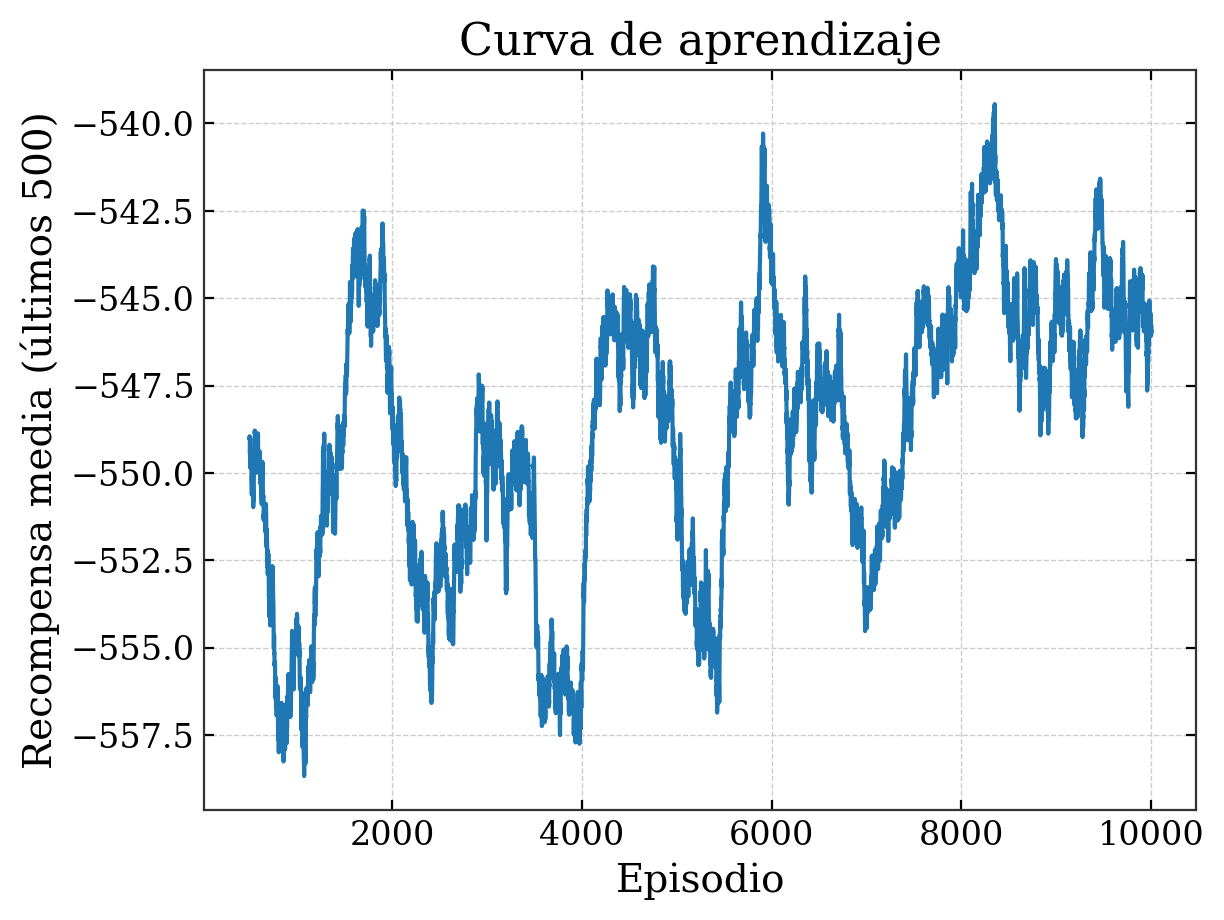

In [125]:
#plot moving average of rewards
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

ma = moving_average(rewards_per_episode, 500)
episodios = np.arange(len(ma)) + 500
plt.plot(episodios, ma)
plt.xlabel('Episodio')
plt.ylabel('Recompensa media (últimos 500)')
plt.title('Curva de aprendizaje')
plt.grid(True)
plt.show()

## Traditional Q-learning approach (baseline)

In [126]:
# Inicialización de la tabla Q|
q_table = np.zeros((MAX_STATE+1, MAX_STATE+1, len(env.actions)))

def choose_action(state, q_table, epsilon=0):
    c1, c2 = state
    if random.random() < epsilon:
        return random.randrange(len(env.actions))
    else:
        return int(np.argmax(q_table[c1, c2, :]))

env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, 
                c2_lambda=LAMBDA_ARRIVAL_C2, 
                max_steps=MAX_STEPS, 
                max_state=MAX_STATE)

rewards_per_episode = []
episode_changes = [3000, 8000]
epsilon = EPSILON

for episode in range(NUM_EPISODES):
    state = tuple(env.reset())   # (c1, c2)
    total_reward = 0.0

    for step in range(MAX_STEPS):
        action = choose_action(state, q_table, epsilon)
        next_state, reward, done, info = env.step(action)
        c1, c2          = state
        next_c1, next_c2 = next_state

        # Bellman update
        best_next = np.max(q_table[next_c1, next_c2, :])
        td_target = reward + GAMMA * best_next
        td_error  = td_target - q_table[c1, c2, action]
        q_table[c1, c2, action] += ALPHA * td_error

        state = tuple(next_state)
        total_reward += reward

        if done:
            break

    # Decaimiento de epsilon
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    rewards_per_episode.append(total_reward)
    
    if episode in episode_changes:
        if episode == episode_changes[0]:
            env.c1_lambda = 5
            env.c2_lambda = 7
        elif episode == episode_changes[1]:
            env.c1_lambda = 3
            env.c2_lambda = 1
    
    if episode % 500 == 0:
        avg = np.mean(rewards_per_episode[-500:])
        print(f"Episode {episode:5d} — AvgReward (últ.500) = {avg:.3f}  ε={epsilon:.3f}")

# Estadísticas finales
print("Reward medio:", np.mean(rewards_per_episode))
print("Reward máximo:", np.max(rewards_per_episode))
print("Reward mínimo:", np.min(rewards_per_episode))

Episode     0 — AvgReward (últ.500) = -642.000  ε=0.999
Episode   500 — AvgReward (últ.500) = -493.024  ε=0.606
Episode  1000 — AvgReward (últ.500) = -411.130  ε=0.367
Episode  1500 — AvgReward (últ.500) = -365.640  ε=0.223
Episode  2000 — AvgReward (últ.500) = -343.022  ε=0.135
Episode  2500 — AvgReward (últ.500) = -327.264  ε=0.082
Episode  3000 — AvgReward (últ.500) = -323.472  ε=0.050
Episode  3500 — AvgReward (últ.500) = -710.852  ε=0.030
Episode  4000 — AvgReward (últ.500) = -701.178  ε=0.018
Episode  4500 — AvgReward (últ.500) = -702.464  ε=0.011
Episode  5000 — AvgReward (últ.500) = -681.898  ε=0.010
Episode  5500 — AvgReward (últ.500) = -694.132  ε=0.010
Episode  6000 — AvgReward (últ.500) = -693.812  ε=0.010
Episode  6500 — AvgReward (últ.500) = -689.496  ε=0.010
Episode  7000 — AvgReward (últ.500) = -681.374  ε=0.010
Episode  7500 — AvgReward (últ.500) = -674.132  ε=0.010
Episode  8000 — AvgReward (últ.500) = -682.964  ε=0.010
Episode  8500 — AvgReward (últ.500) = -361.452  

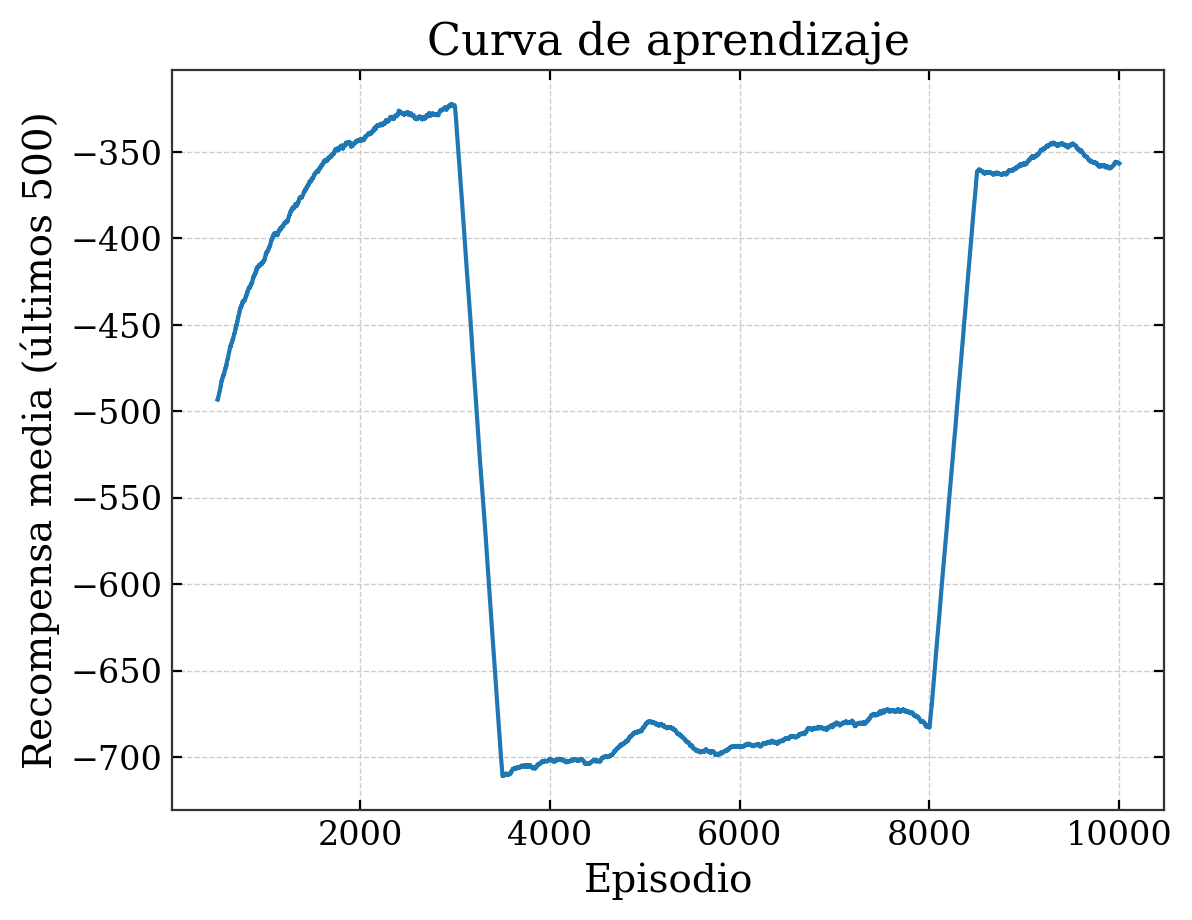

In [127]:
ma_tradq = moving_average(rewards_per_episode, 500)
episodios = np.arange(len(ma_tradq)) + 500
plt.plot(episodios, ma_tradq)
plt.xlabel('Episodio')
plt.ylabel('Recompensa media (últimos 500)')
plt.title('Curva de aprendizaje')
plt.grid(True)
plt.show()

## Adaptive Agent

In [133]:
# Inicialización del entorno y parámetros
N_ROWS = MAX_STATE + 1
N_COLS = MAX_STATE + 1

EXPLOTATION = 0.2

# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 4),
    actions=[0,1,2],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=.001, # más grande => más errático
    alpha=ALPHA,
    alpha_max=0.15,
    td_threshold=20, # más pequeño => más sensible
    min_epsilon=EPSILON_MIN,
)


# Inicialización del Page-Hinkley Test
ph_test = PageHinkleyTest(threshold=1000)

# Variables para el seguimiento del entrenamiento
learning_curve = []
exploration_curve = []

change_detection = []

env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, 
                c2_lambda=LAMBDA_ARRIVAL_C2, 
                max_steps=MAX_STEPS, 
                max_state=MAX_STATE)
rewards_per_episode = []

episode_changes = [3000, 8000]


eps = 1
# Bucle de entrenamiento
for ep in range(NUM_EPISODES):
    state = tuple(env.reset())      # (c1, c2)
    agent.current_state = state
    total_reward = 0.0
    
    for step in range(MAX_STEPS):
        # 1) Elegir acción ε-greedy
        action = agent.choose_action(eps)

        # 2) Interactuar con el entorno
        next_state, reward, done, info = env.step(action)
        next_state = tuple(next_state)

        # 3) Guardar recompensa
        total_reward += reward

        # 4) Actualizar Q-value con tasa adaptativa
        agent.update_q_value(
            current_state=state,
            action=action,
            reward=reward,
            next_state=next_state
        )

        state = next_state
        agent.current_state = next_state

        if done:
            break
        
                
    # Decay de ε **por episodio**:
    eps = max(EPSILON_MIN, eps * EPSILON_DECAY)
    
    if ph_test.update(total_reward):
        print(f"Cambio detectado en episodio {ep} con recompensa {total_reward}", eps)
        change_detection.append(ep)
        
        eps = 1 # Aumentar exploración
        # Definir nuevas acciones ---
        if len(env.actions) < 4:
            extra_actions = [
                {'C1_service': 7, 'C2_service':  3},  # muy prioritario a C1
                {'C1_service':  3, 'C2_service': 7},  # muy prioritario a C2
            ]

            # Concatenar al conjunto actual ---
            updated_actions = env.actions + extra_actions
            env.actions   = updated_actions
            agent.update_actions(updated_actions)
        
        ph_test.reset()
        
    rewards_per_episode.append(total_reward)
    
    if ep in episode_changes:
        if ep == episode_changes[0]:
            env.c1_lambda = 5
            env.c2_lambda = 7
        elif ep == episode_changes[1]:
            env.c1_lambda = 3
            env.c2_lambda = 1
        
            
    if ep % 500 == 0:
        avg_last = np.mean(rewards_per_episode[-500:])
        print(f"Episodio {ep:5d} — Reward medio últimos 500 = {avg_last:.3f} — ε={eps:.3f} - α={agent.effective_alpha:.3f}")
    
            
print("Reward medio global:", np.mean(rewards_per_episode))
print("Reward máximo:",       np.max(rewards_per_episode))
print("Reward mínimo:",       np.min(rewards_per_episode))

Episodio     0 — Reward medio últimos 500 = -388.000 — ε=0.999 - α=0.148
Episodio   500 — Reward medio últimos 500 = -486.586 — ε=0.606 - α=0.101
Episodio  1000 — Reward medio últimos 500 = -405.192 — ε=0.367 - α=0.106
Episodio  1500 — Reward medio últimos 500 = -360.138 — ε=0.223 - α=0.100
Episodio  2000 — Reward medio últimos 500 = -345.312 — ε=0.135 - α=0.100
Episodio  2500 — Reward medio últimos 500 = -320.658 — ε=0.082 - α=0.102
Episodio  3000 — Reward medio últimos 500 = -313.468 — ε=0.050 - α=0.100
Cambio detectado en episodio 3003 con recompensa -728.0 0.04951384249760823
Episodio  3500 — Reward medio últimos 500 = -601.292 — ε=0.608 - α=0.100
Episodio  4000 — Reward medio últimos 500 = -542.174 — ε=0.369 - α=0.100
Episodio  4500 — Reward medio últimos 500 = -501.538 — ε=0.224 - α=0.150
Episodio  5000 — Reward medio últimos 500 = -476.454 — ε=0.136 - α=0.150
Episodio  5500 — Reward medio últimos 500 = -457.022 — ε=0.082 - α=0.100
Episodio  6000 — Reward medio últimos 500 = -443

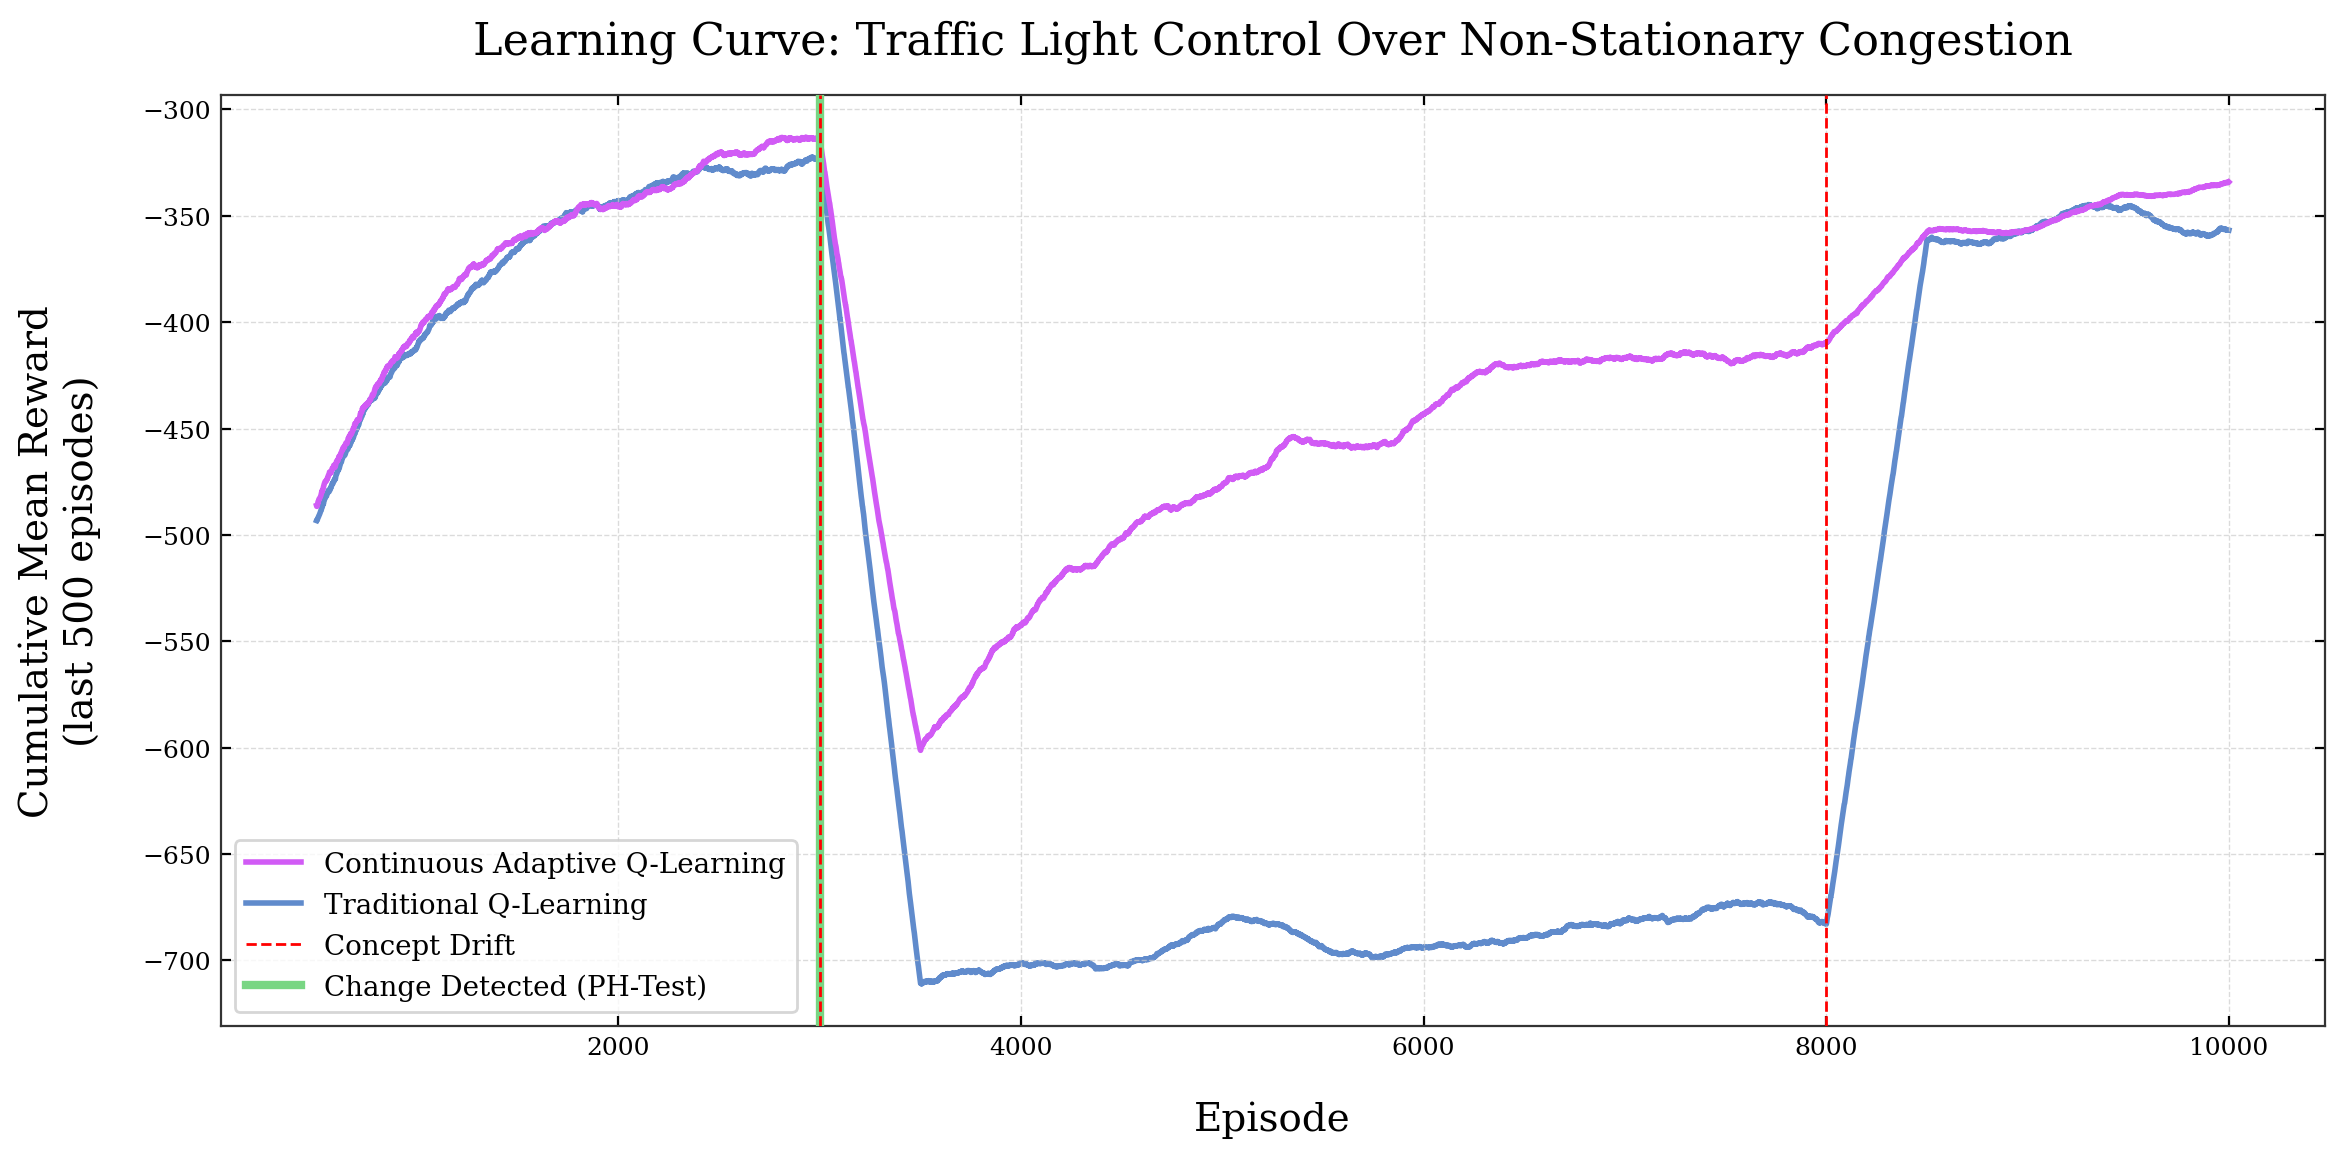

In [134]:
ma = moving_average(rewards_per_episode, 500)
episodios = np.arange(len(ma)) + 500

plt.figure(figsize=(12, 6))
plt.plot(episodios, ma, label='Continuous Adaptive Q-Learning', color='#d15bf5', linewidth=2, zorder=10)
plt.plot(episodios, ma_tradq, label='Traditional Q-Learning', color='#608bcc', linestyle='-', linewidth=2, zorder=1)

for v in episode_changes:
    plt.axvline(x=v, color='red', linestyle='--', linewidth=1, zorder=30, label='Concept Drift' if v == episode_changes[0] else "")
for i, c in enumerate(change_detection):
    plt.axvline(x=c, color='#78d683', linestyle='-', linewidth=3, zorder=10, label='Change Detected (PH-Test)' if i == 0 else "")

plt.xlabel('Episode', fontsize=14, labelpad=15)
plt.ylabel('Cumulative Mean Reward\n(last 500 episodes)', fontsize=14, labelpad=15)
plt.title('Learning Curve: Traffic Light Control Over Non-Stationary Congestion', fontsize=16, pad=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
# change zorder of legend so axvline red be below
plt.legend(fontsize=10, frameon=True, ncol=1, loc='lower left').set_zorder(50)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.savefig('traffic_learning_curve.png', dpi=300, bbox_inches='tight')

plt.show()

{'served_c1': 3, 'arr1_during': 4, 'served_c2': 4, 'arr2_during': 3, 'penalty': 9}


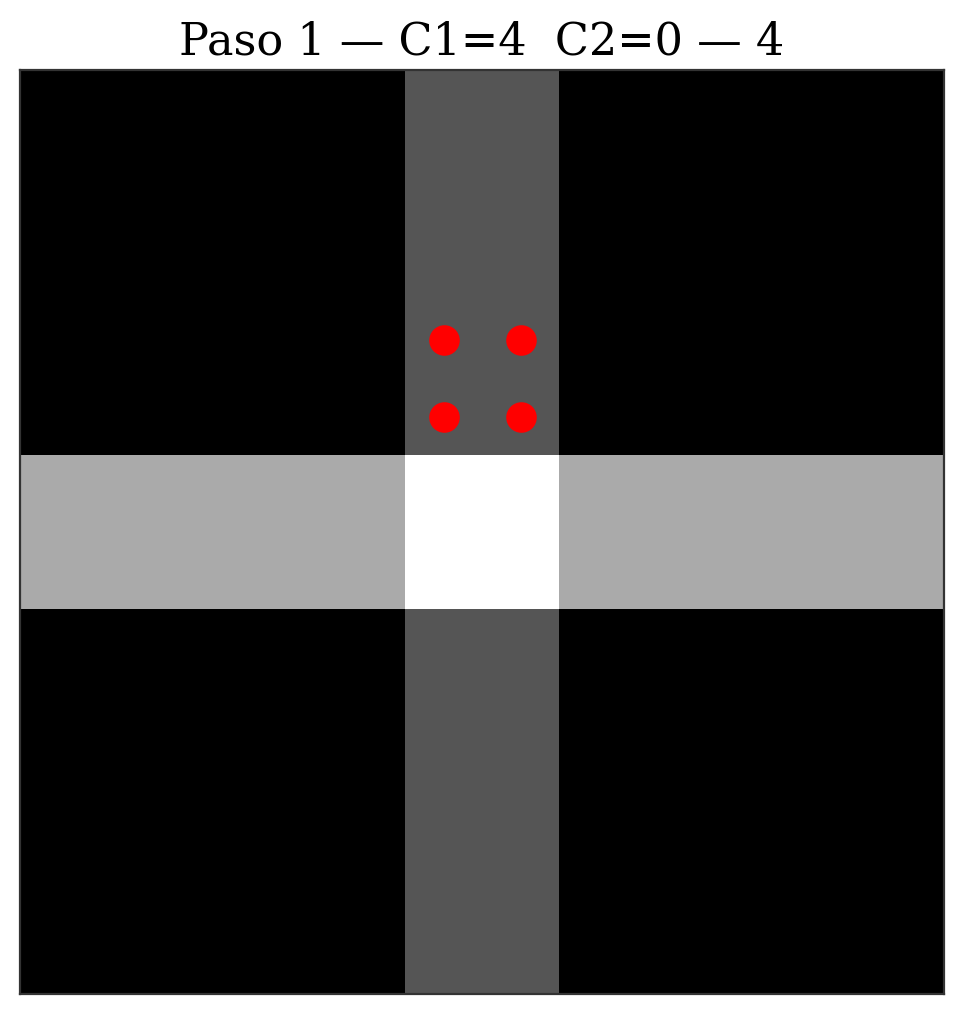

{'served_c1': 3, 'arr1_during': 4, 'served_c2': 0, 'arr2_during': 0, 'penalty': 9}


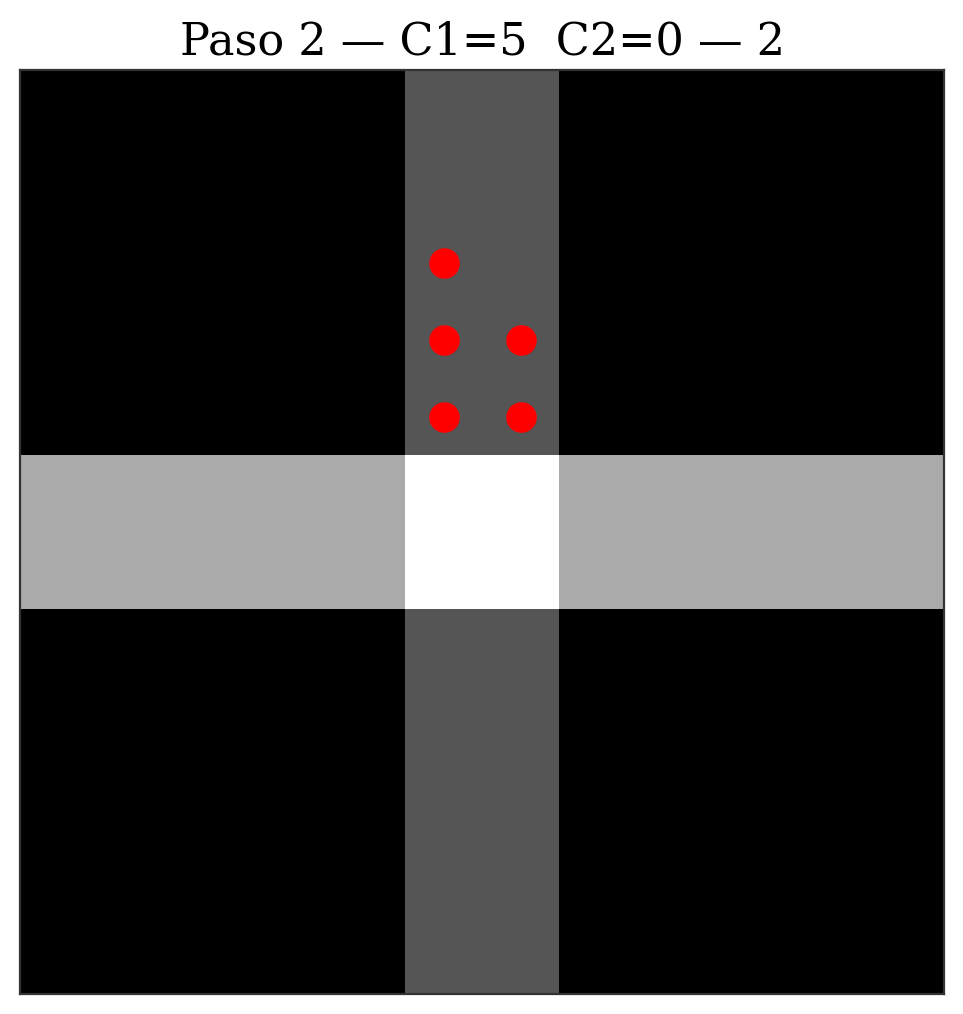

{'served_c1': 5, 'arr1_during': 5, 'served_c2': 0, 'arr2_during': 0, 'penalty': 6}


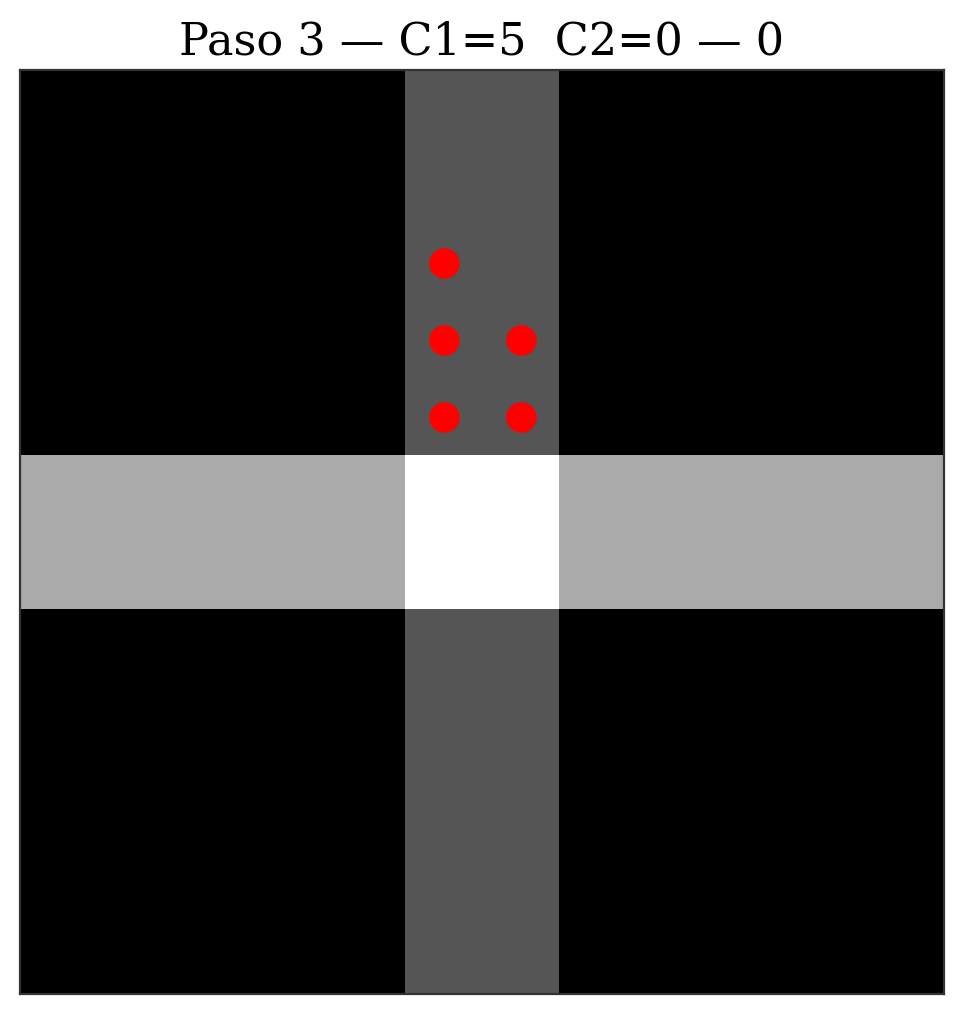

{'served_c1': 5, 'arr1_during': 2, 'served_c2': 1, 'arr2_during': 1, 'penalty': 3}


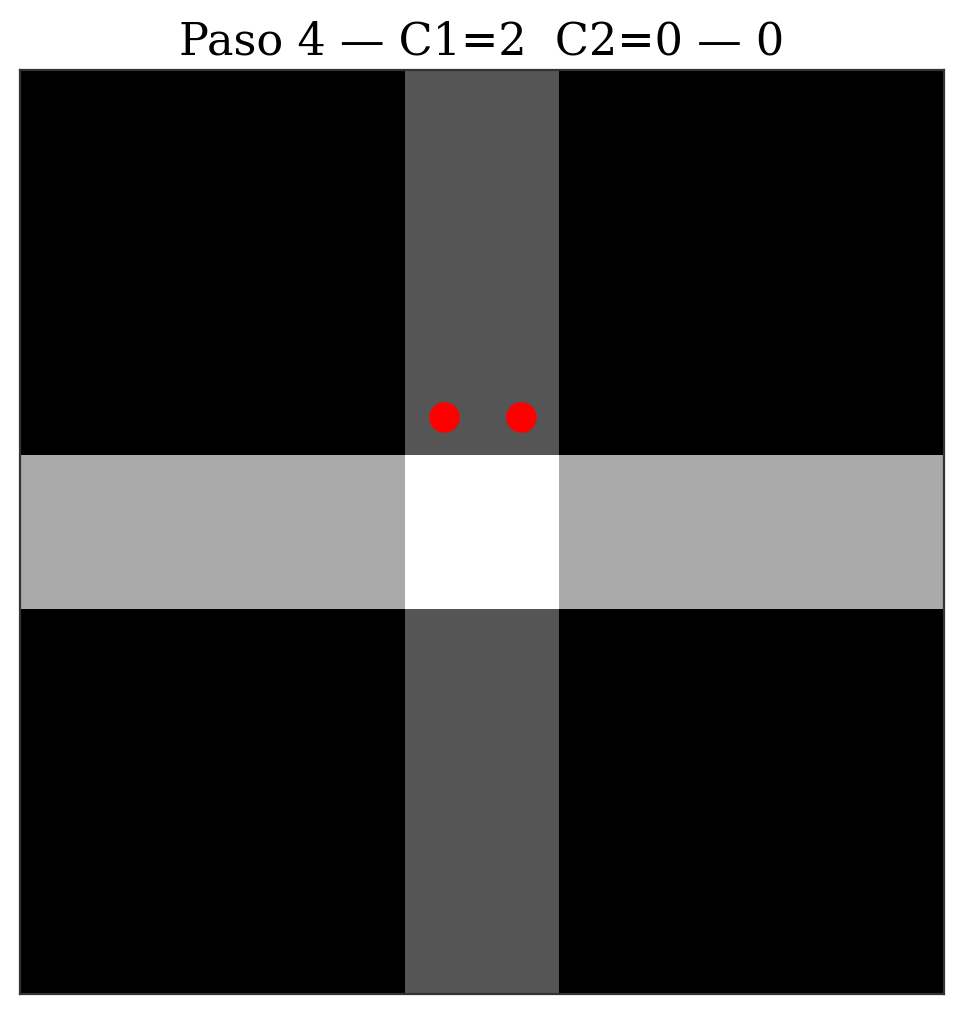

{'served_c1': 2, 'arr1_during': 3, 'served_c2': 1, 'arr2_during': 1, 'penalty': 9}


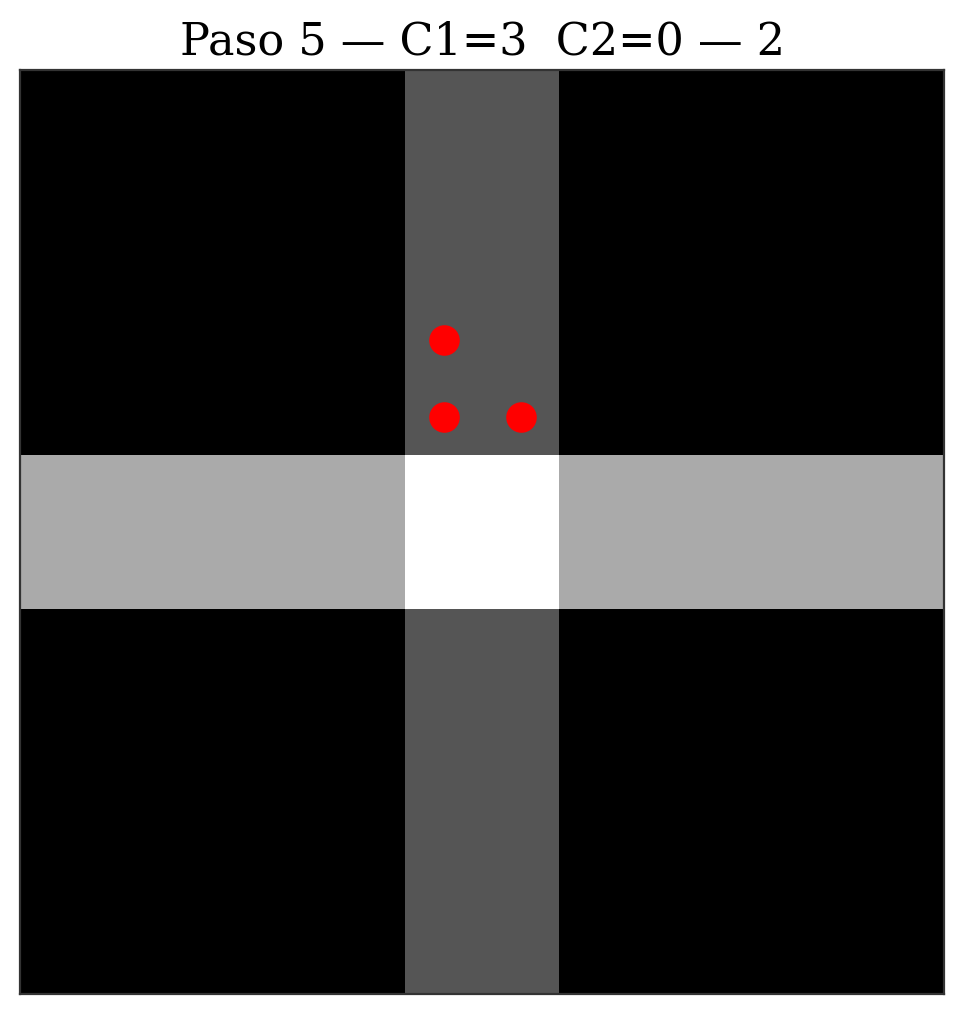

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 1, 'arr2_during': 1, 'penalty': 6}


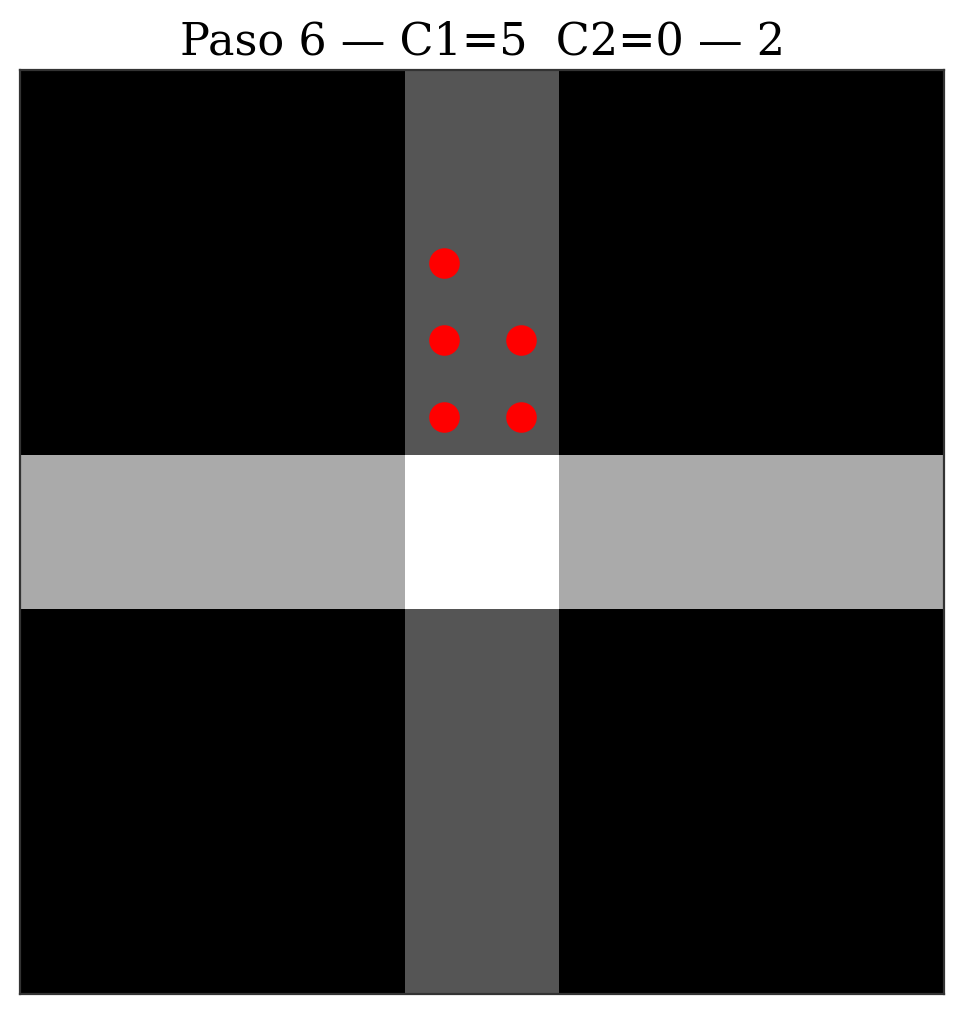

{'served_c1': 5, 'arr1_during': 2, 'served_c2': 1, 'arr2_during': 1, 'penalty': 3}


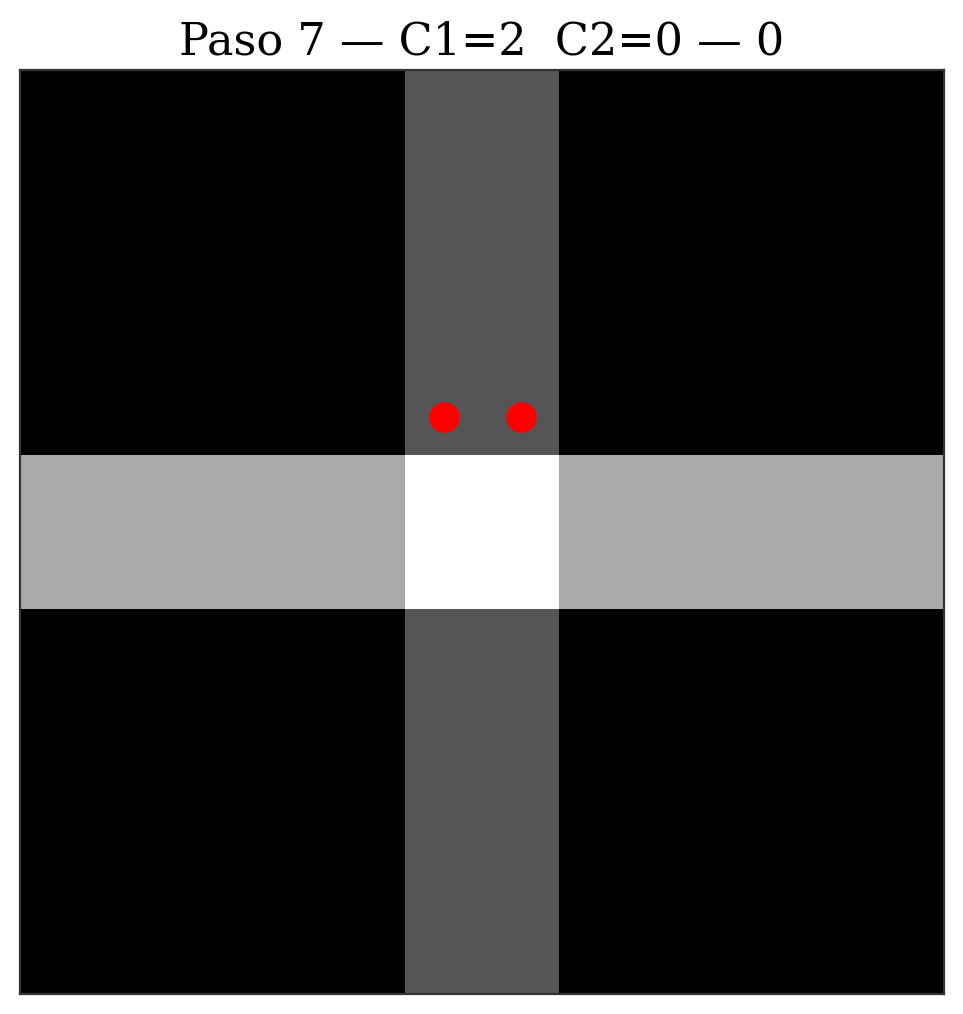

{'served_c1': 2, 'arr1_during': 3, 'served_c2': 0, 'arr2_during': 0, 'penalty': 12}


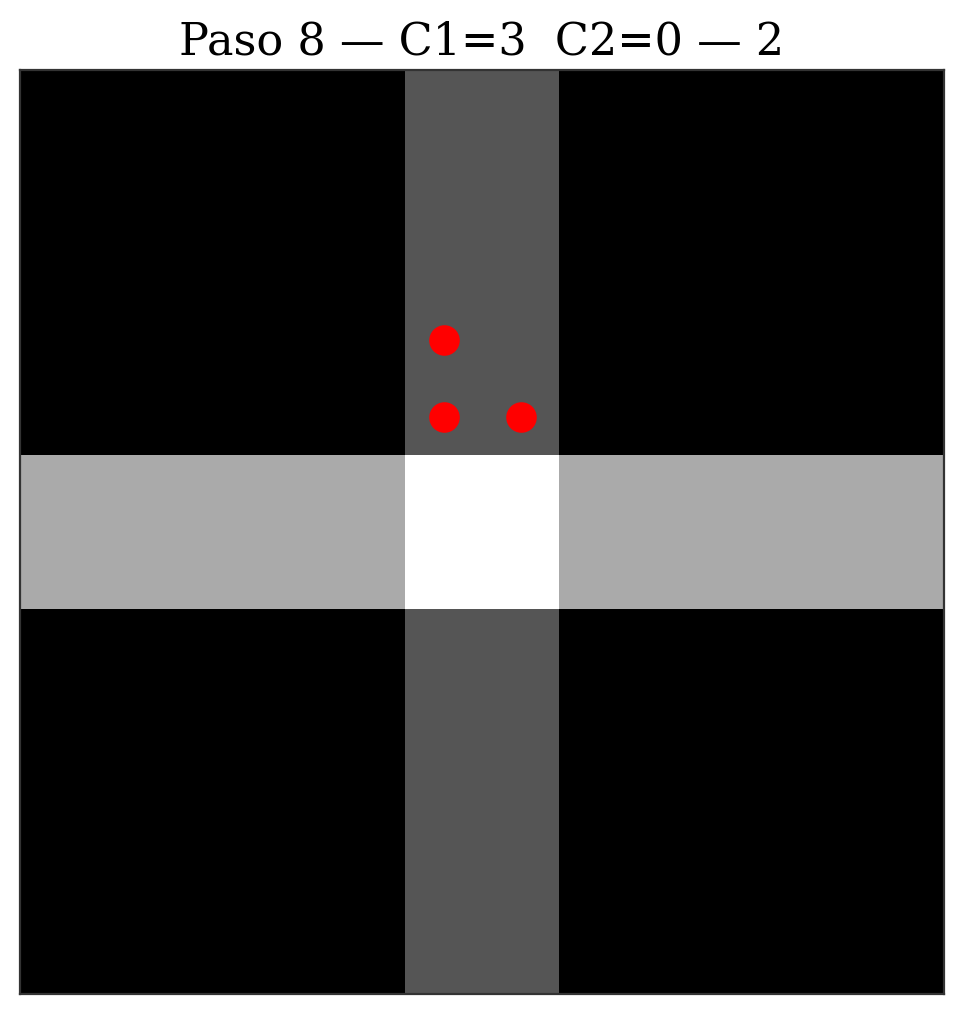

{'served_c1': 3, 'arr1_during': 6, 'served_c2': 0, 'arr2_during': 0, 'penalty': 9}


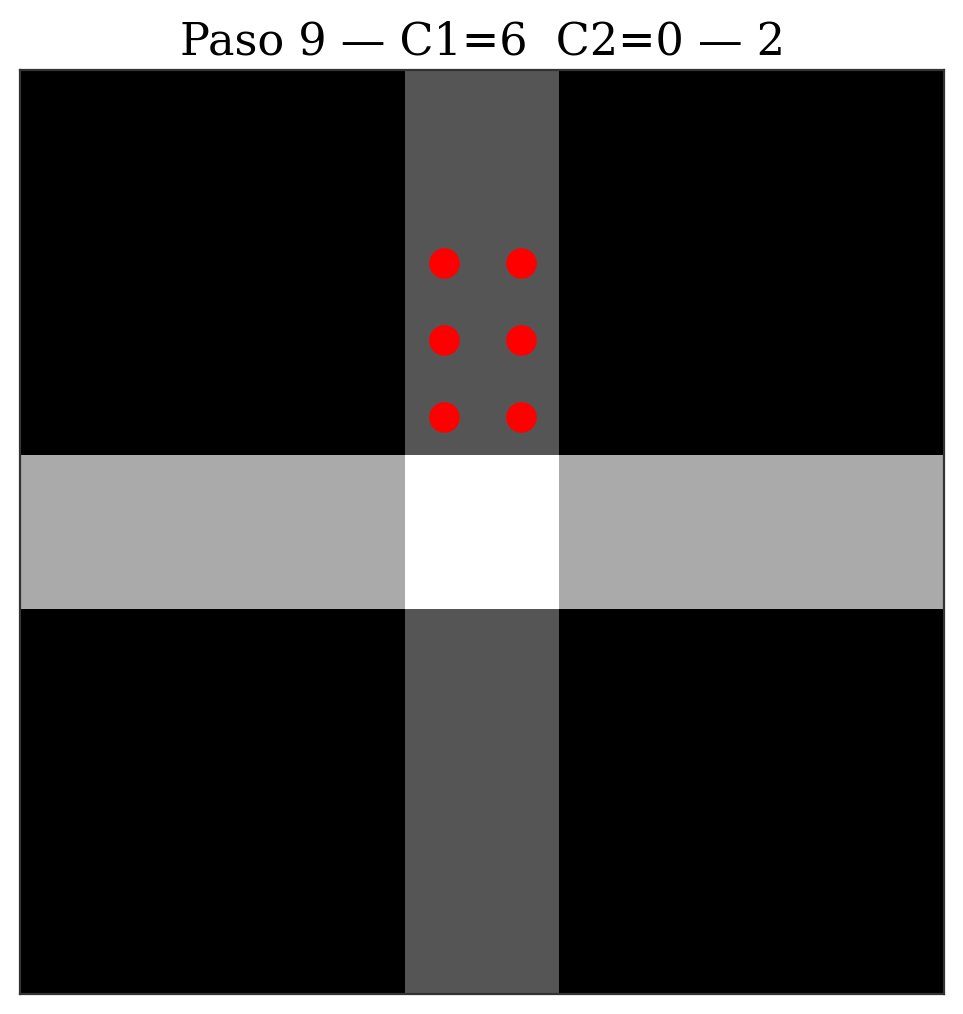

{'served_c1': 6, 'arr1_during': 4, 'served_c2': 1, 'arr2_during': 1, 'penalty': 9}


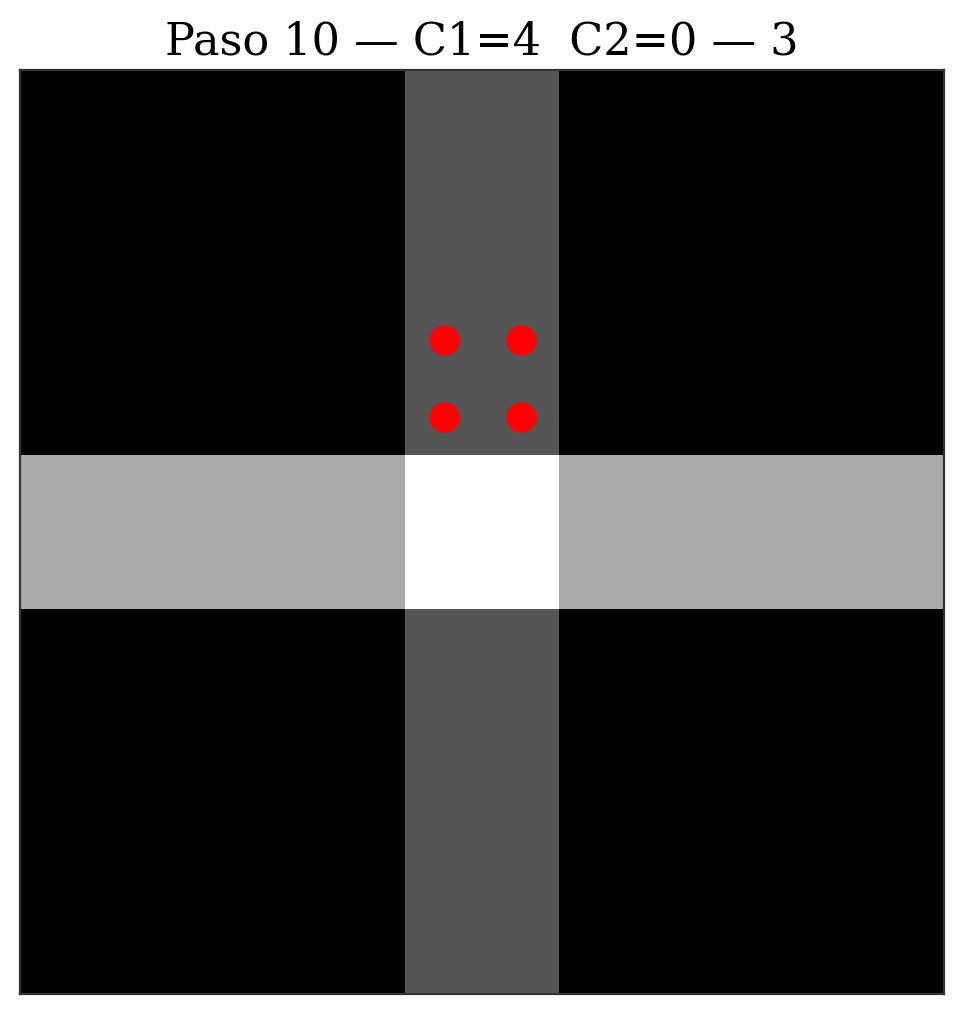

{'served_c1': 3, 'arr1_during': 2, 'served_c2': 0, 'arr2_during': 0, 'penalty': 9}


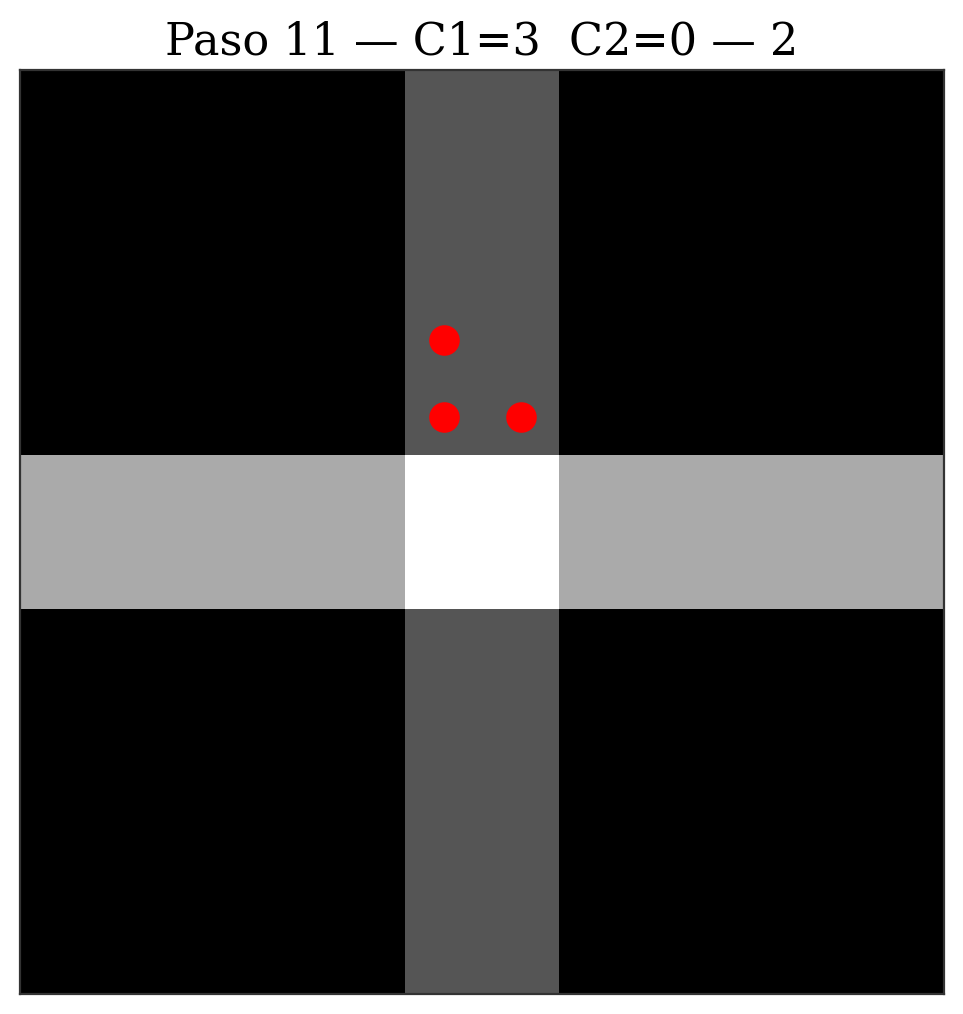

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 2, 'arr2_during': 2, 'penalty': 3}


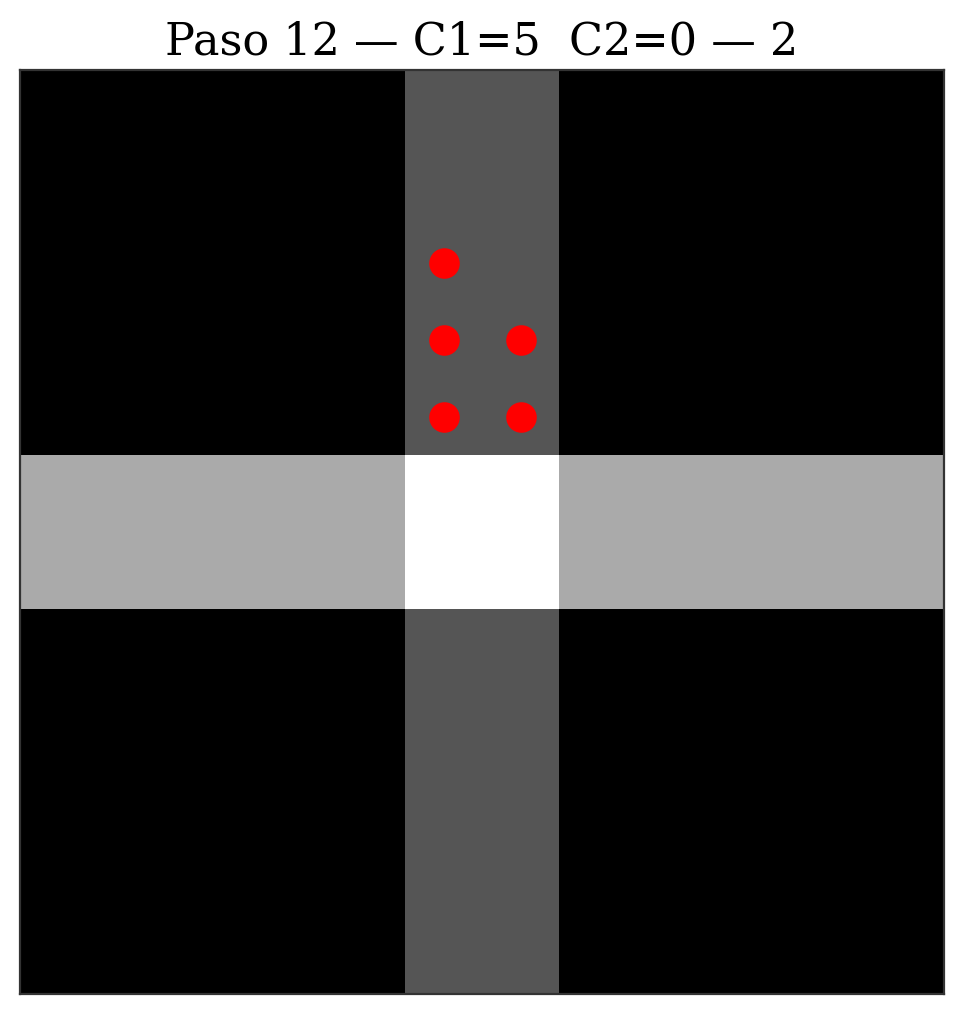

{'served_c1': 5, 'arr1_during': 4, 'served_c2': 1, 'arr2_during': 1, 'penalty': 3}


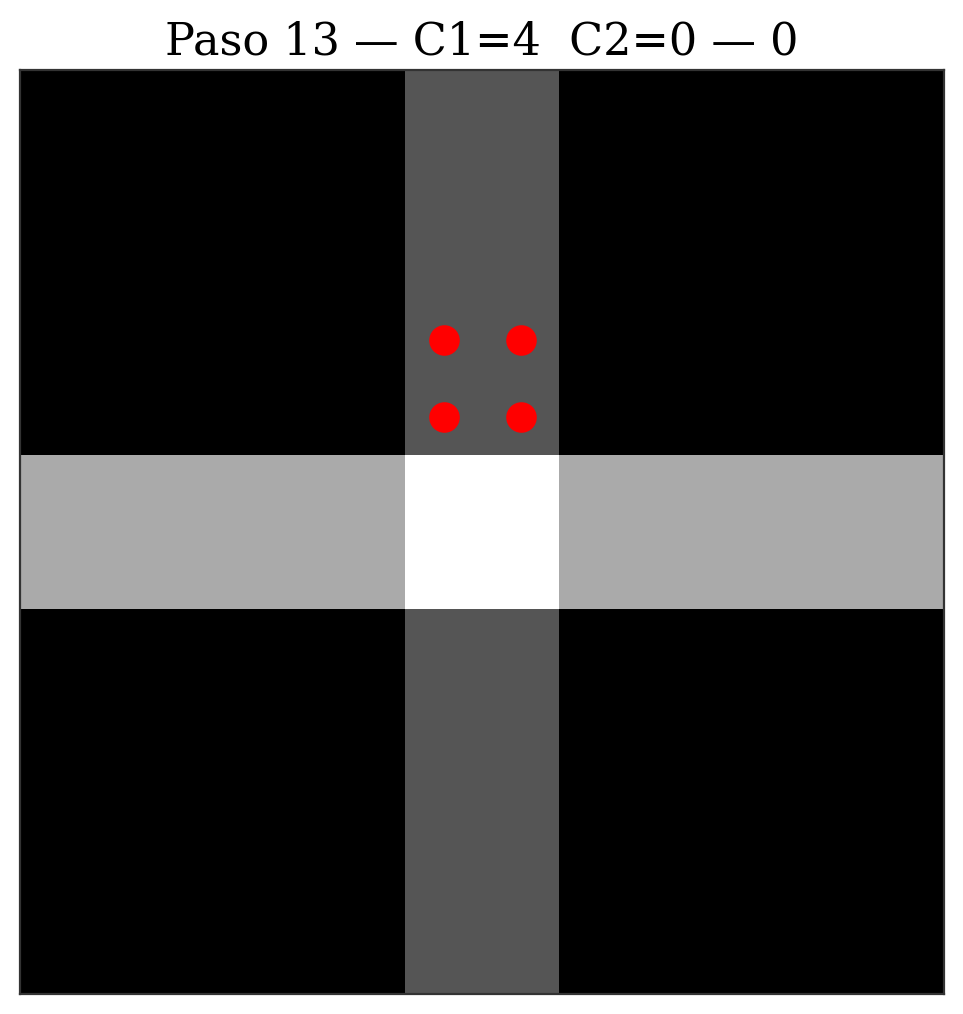

{'served_c1': 3, 'arr1_during': 2, 'served_c2': 0, 'arr2_during': 0, 'penalty': 9}


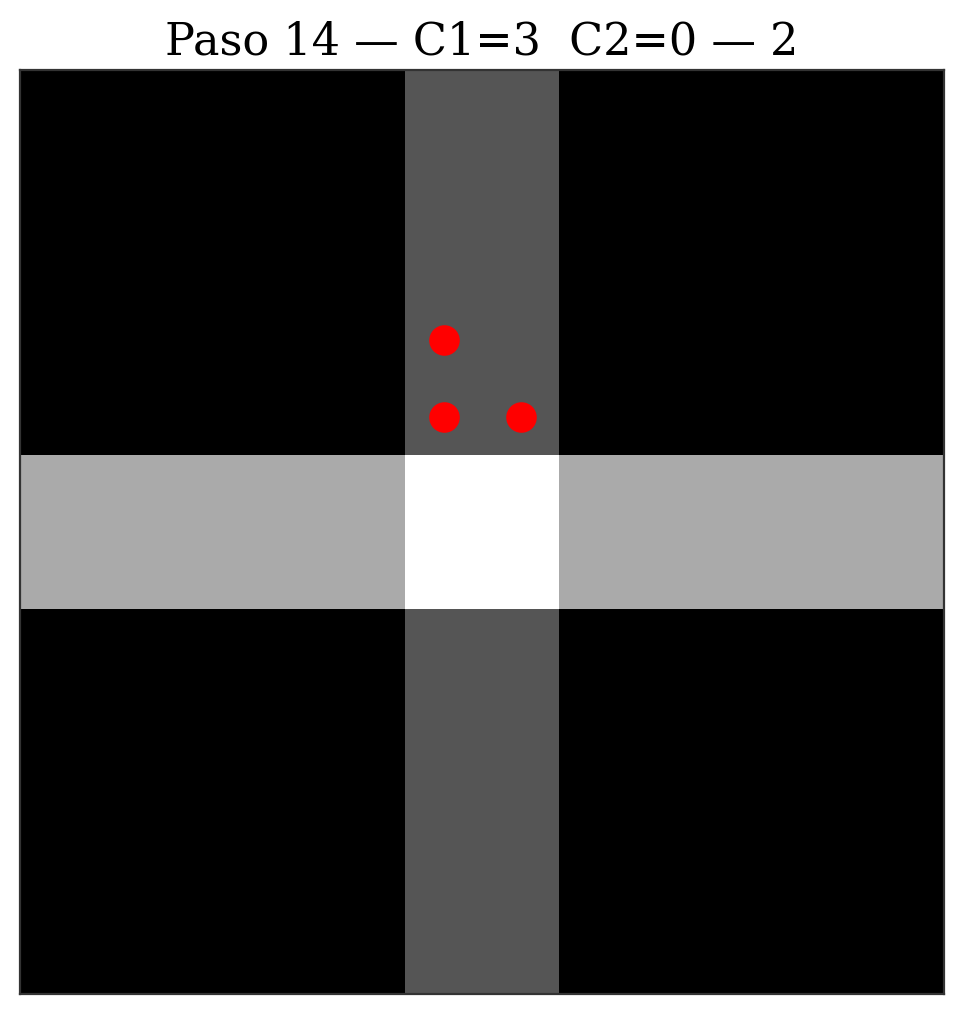

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 0, 'arr2_during': 0, 'penalty': 9}


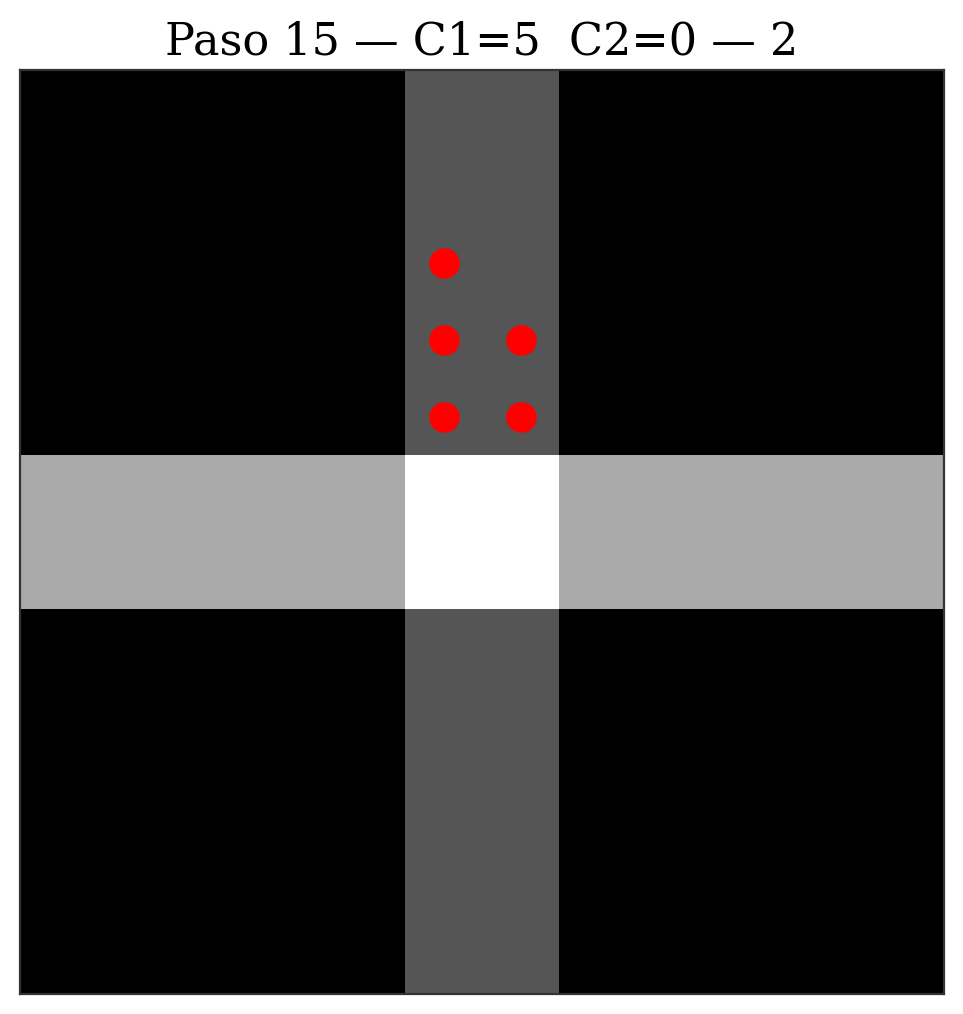

{'served_c1': 5, 'arr1_during': 3, 'served_c2': 2, 'arr2_during': 2, 'penalty': 0}


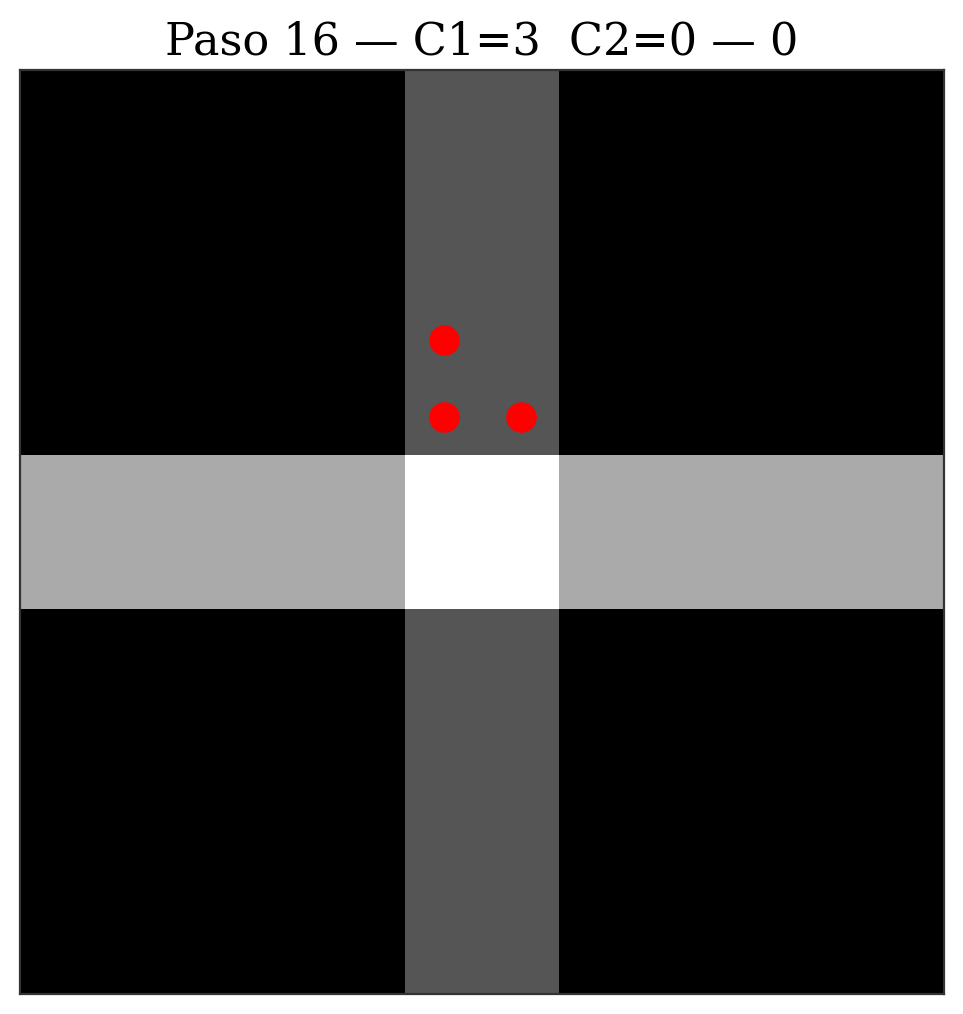

{'served_c1': 3, 'arr1_during': 2, 'served_c2': 3, 'arr2_during': 3, 'penalty': 0}


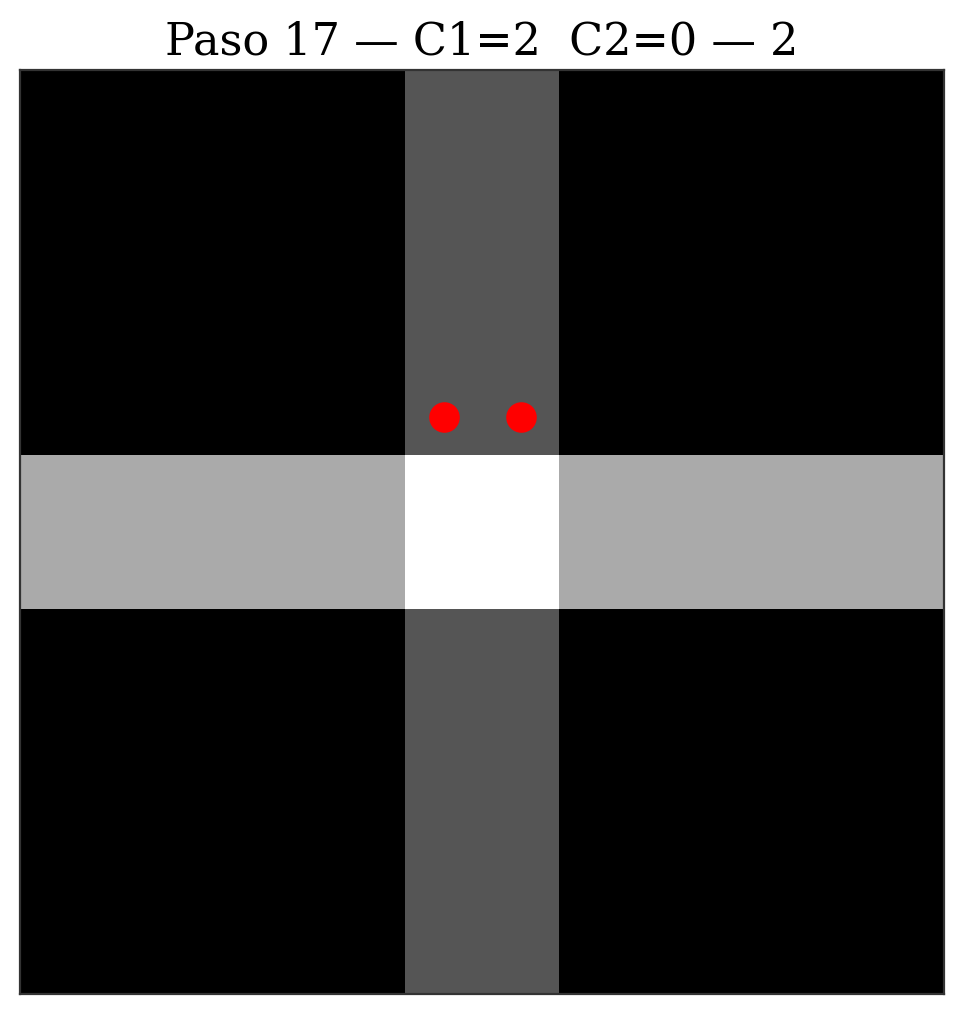

{'served_c1': 2, 'arr1_during': 5, 'served_c2': 1, 'arr2_during': 1, 'penalty': 9}


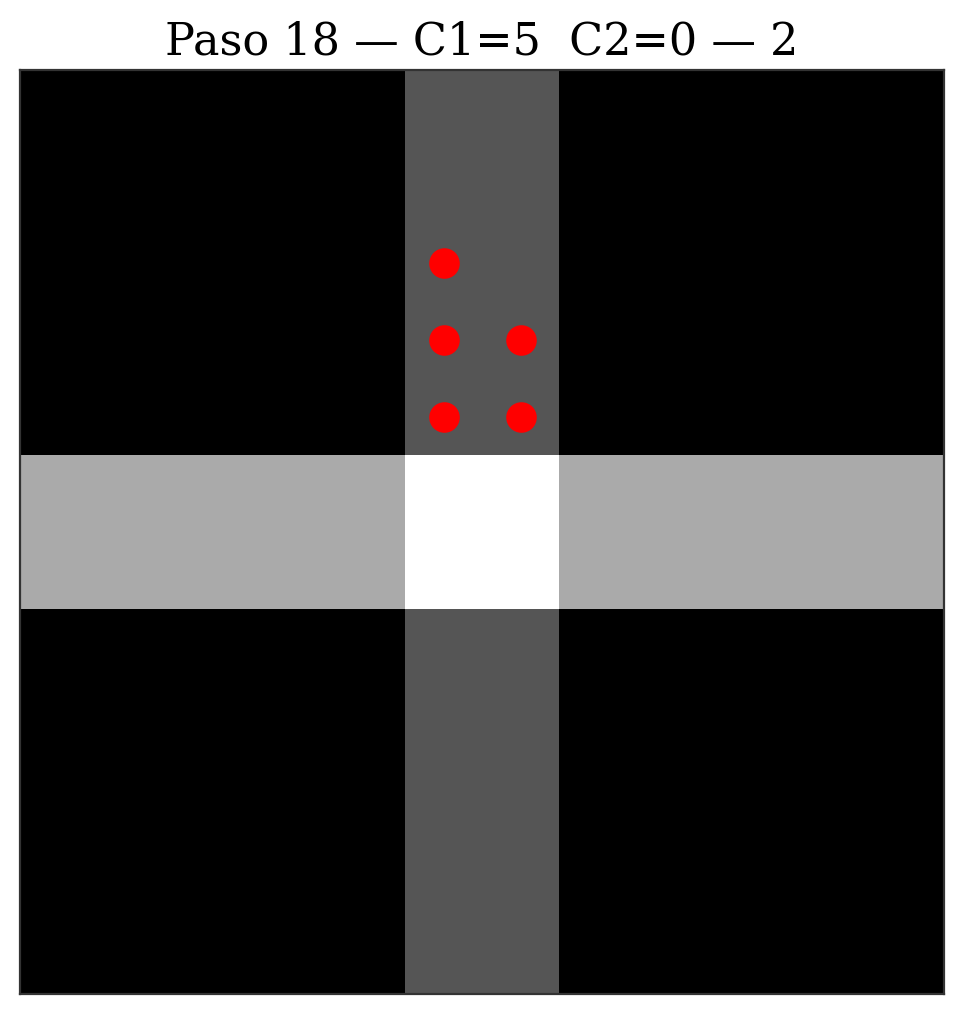

{'served_c1': 5, 'arr1_during': 2, 'served_c2': 0, 'arr2_during': 0, 'penalty': 6}


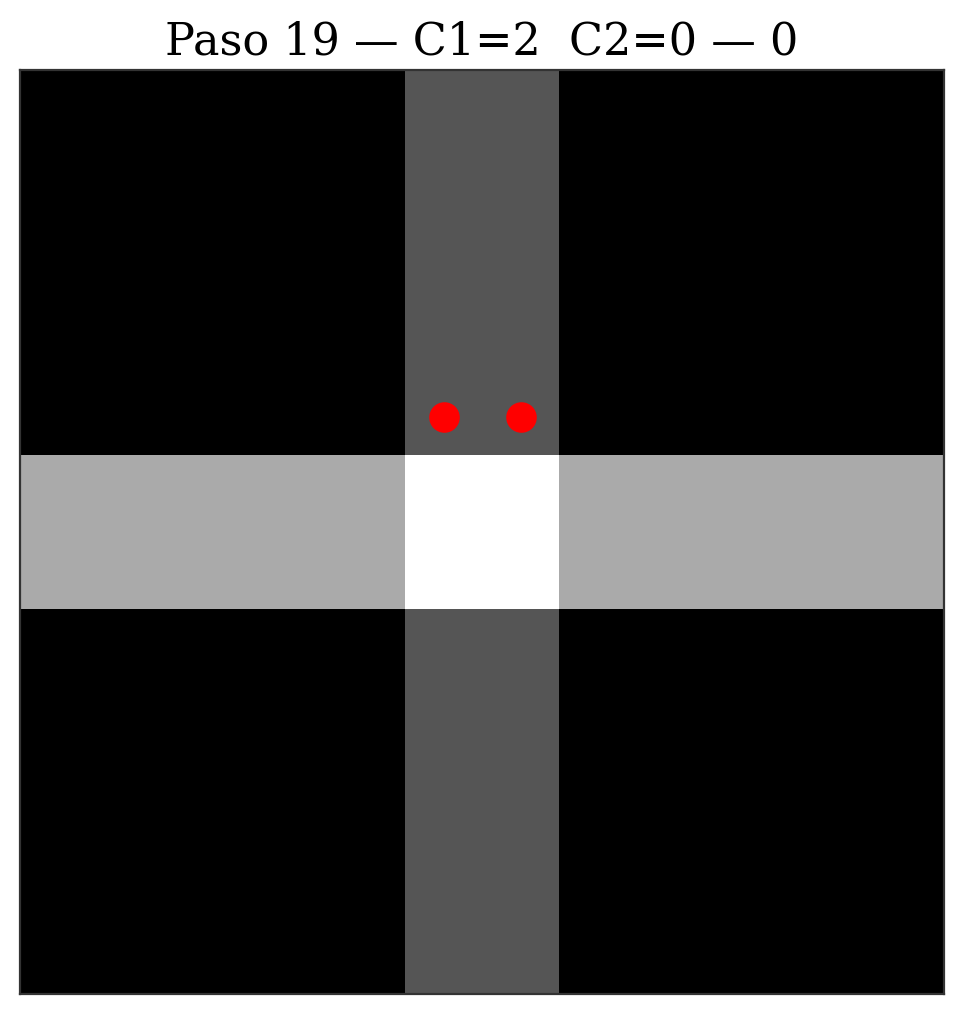

{'served_c1': 2, 'arr1_during': 1, 'served_c2': 1, 'arr2_during': 1, 'penalty': 9}


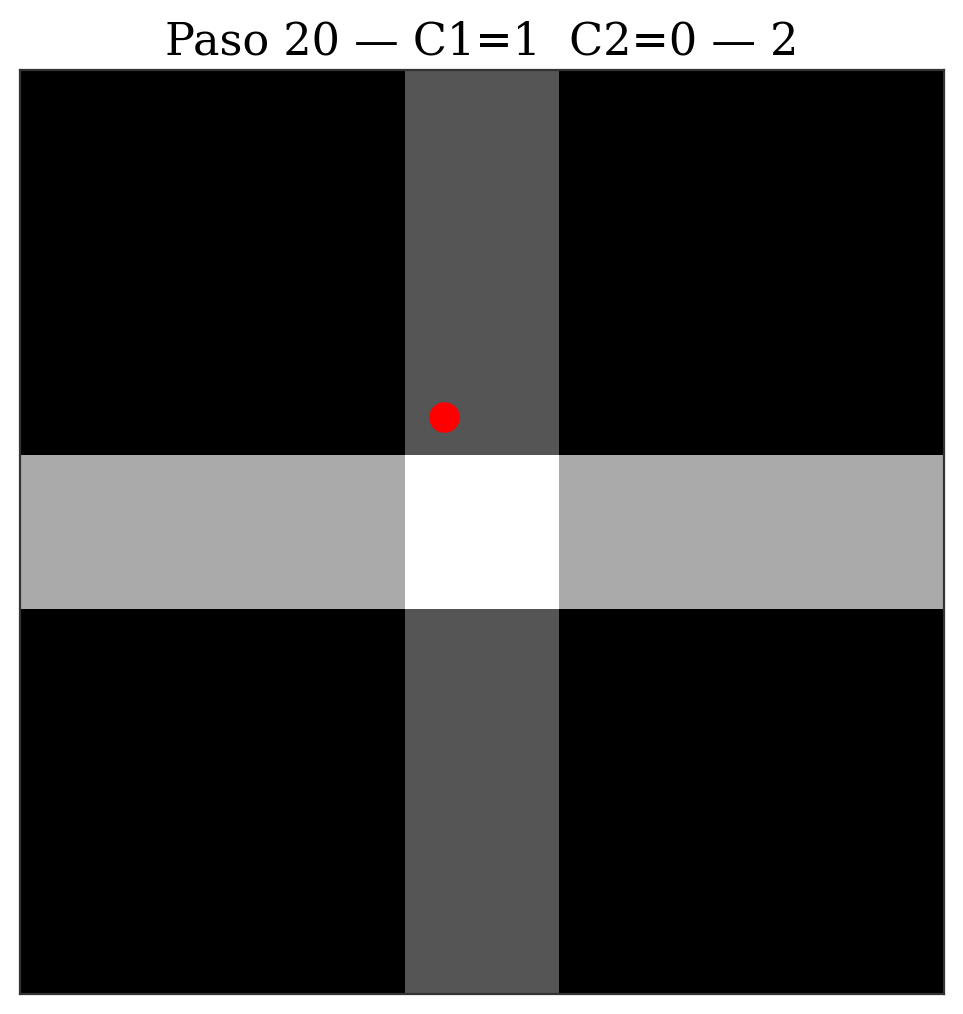

In [130]:
# simulate agent:
state = env.reset()
for _ in range(20):
    action = agent.get_best_action(state)[0]
    state, reward, done, info = env.step(action)
    print(info)
    env.render(title=f" — {agent.map_ix_action[action]}")

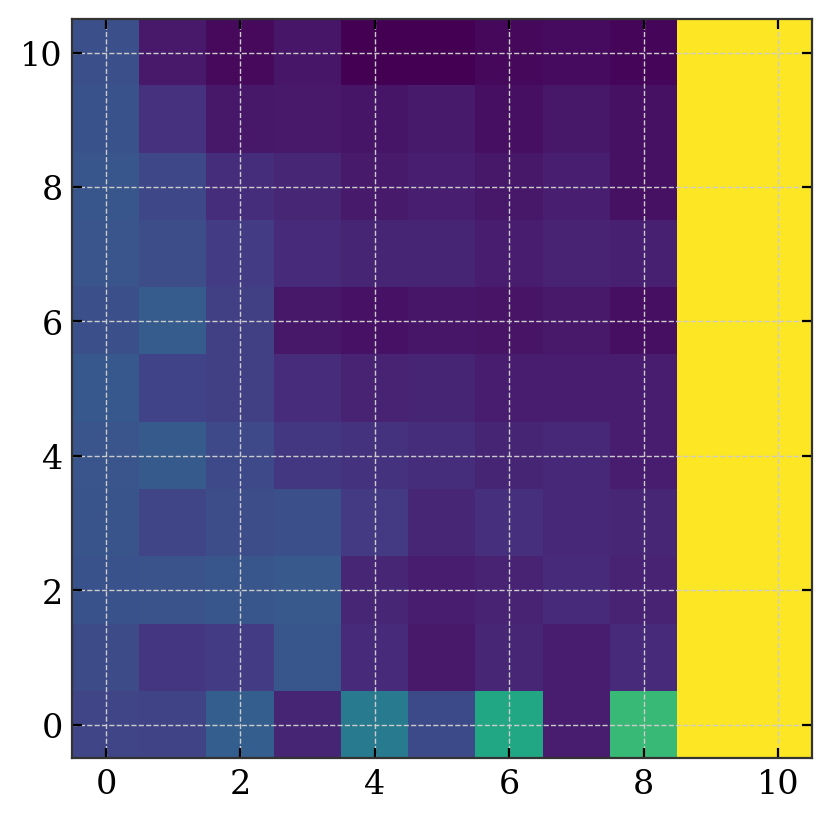

In [131]:
plt.imshow(np.max(agent.q_knowledge, axis=0), origin='lower')

In [132]:
np.max(agent.q_knowledge, axis=0)

array([[-118.93110736, -119.03272259, -105.21294326, -134.26205443,
         -88.06157661, -116.4412776 ,  -60.79030932, -138.45225032,
         -48.64794458,    0.        ,    0.        ],
       [-116.08174047, -126.46459328, -123.15290556, -109.89754948,
        -131.67925453, -139.97705547, -134.12521985, -138.61986351,
        -131.99403069,    0.        ,    0.        ],
       [-112.55670368, -111.77136244, -109.99293852, -108.45083961,
        -133.74331365, -138.91238839, -135.11770599, -132.48943928,
        -135.25109803,    0.        ,    0.        ],
       [-110.92918571, -118.74524002, -114.84296855, -113.48374269,
        -124.4951077 , -133.83489072, -129.83809252, -133.06130472,
        -134.20791548,    0.        ,    0.        ],
       [-110.30245902, -107.53480533, -117.22579038, -125.82950784,
        -128.06522343, -130.57400292, -134.3184151 , -132.79903597,
        -137.83625902,    0.        ,    0.        ],
       [-108.75893778, -119.81451739, -121.4619681